In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
%config InlineBackend.figure_format='retina'

In [2]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)

In [3]:
def last_block_err(data, L):
    M = np.size(data) #total number of values
    #L is the size of block
    N = int(M/L) #number of blocks depending on size of the block
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)
    for i in range(N):
        sum1 = 0
        sum2 = 0
        for j in range(L):
            k = j+i*L
            sum1 += data[k]
            sum2 += data[k]*data[k]
        ave[i] = sum1/L     
        av2[i] = (ave[i])**2  
    
    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i)
    return err_prog[-1];       

In [4]:
def data_block_err(data, L):
    out = []
    for i in L:
        out.append(last_block_err(data,i))
    return out

## Exercise 07: Metropolis Argon simulation and radial distribution function

In the following exercise there are multiple tasks:
- implementation of tail corrections to the calculation of potential energy and pressure of exercise 04
- evaluation of time autocorrelation functions in order to equilibrate the Metropolis simulaiton
- evaluation of radial distribution function
- evalutation of energy per particle and pressure

### 50% empirical rule and data blocking values

As already mentioned in pervious exercise the acceptance rate should be fixed at around 50%. In order to get this result the following moves parameters are chosen:
- solid phase: $\Delta r = 0.11$
- liquid phase: $\Delta r = 0.20$
- gas phase: $\Delta r = 0.60$

In the gas phase it can be noticed that the acceptance rate is always higher than 50%. This is because being the density much lower many more configurations are accepted. The data blocking for each analysis has been conducted choosing:
- total MC steps: $N = 10^5$
- bins: $M = 100$

### Tail corrections

In exercise 04 the cut-off of the potential was not corrected in any sort of way. Tha main way to better this approximation is to implement the so called tail correction; since any two-body interaction can be entirely computed knowing only the radial distribution funciton $g(r)$ (probability to find another particle at distance $r$ from a fixed one) the standard procedure is to fix $g(x) = 1$ outside the spherical cut-off. The following quantities are then the tail correction to the potential and the pressure computed for a Lennard Jones potential:
$$
\delta V/N = \frac{8\pi\rho}{3r_{cut}^3}\left[\frac{1}{3r^6}-1\right]
$$

$$
\delta p = \frac{32\pi\rho}{3r_{cut}^3}\left[\frac{1}{3r^6}-\frac{1}{2}\right]
$$

The implementation in the code is then straightforward.

### Time autocorrelation function

The simulation of the system is performed using the Metropolis algorithm. The main disadvantage is the correlation between successive moves: in order to give an estimate of the "memory time" the algorithm has the *autocorrelation function* is evaluated for different $\tau$ ($x$ indicates any kind of observable).
$$
Ac(\tau) = \frac{cov\langle x(t)x(t+\tau)\rangle}{\sigma^2_x}
$$

### Error analysis

In order to perform data blocking the size of each block has to be chosen. Below are shown plots for the error of energy in each phase against the size of the blocks. Once the error saturates the block size is chosen.

### Equilibration time

As any Monte Carlo simulation equilibration time is needed. In this case the observable computed is energy for the three phases. Once it stabilizes around a stable value the choice of equilibration time is taken.

In [5]:
MC_step, solid_energy_equi = np.loadtxt("Solid_sim/Equi_solid.dat", usecols = (0,1), unpack = True)
MC_step, liquid_energy_equi = np.loadtxt("Liquid_sim/Equi_liquid.dat", usecols = (0,1), unpack = True)
MC_step, gas_energy_equi = np.loadtxt("Gas_sim/Equi_gas.dat", usecols = (0,1), unpack = True)

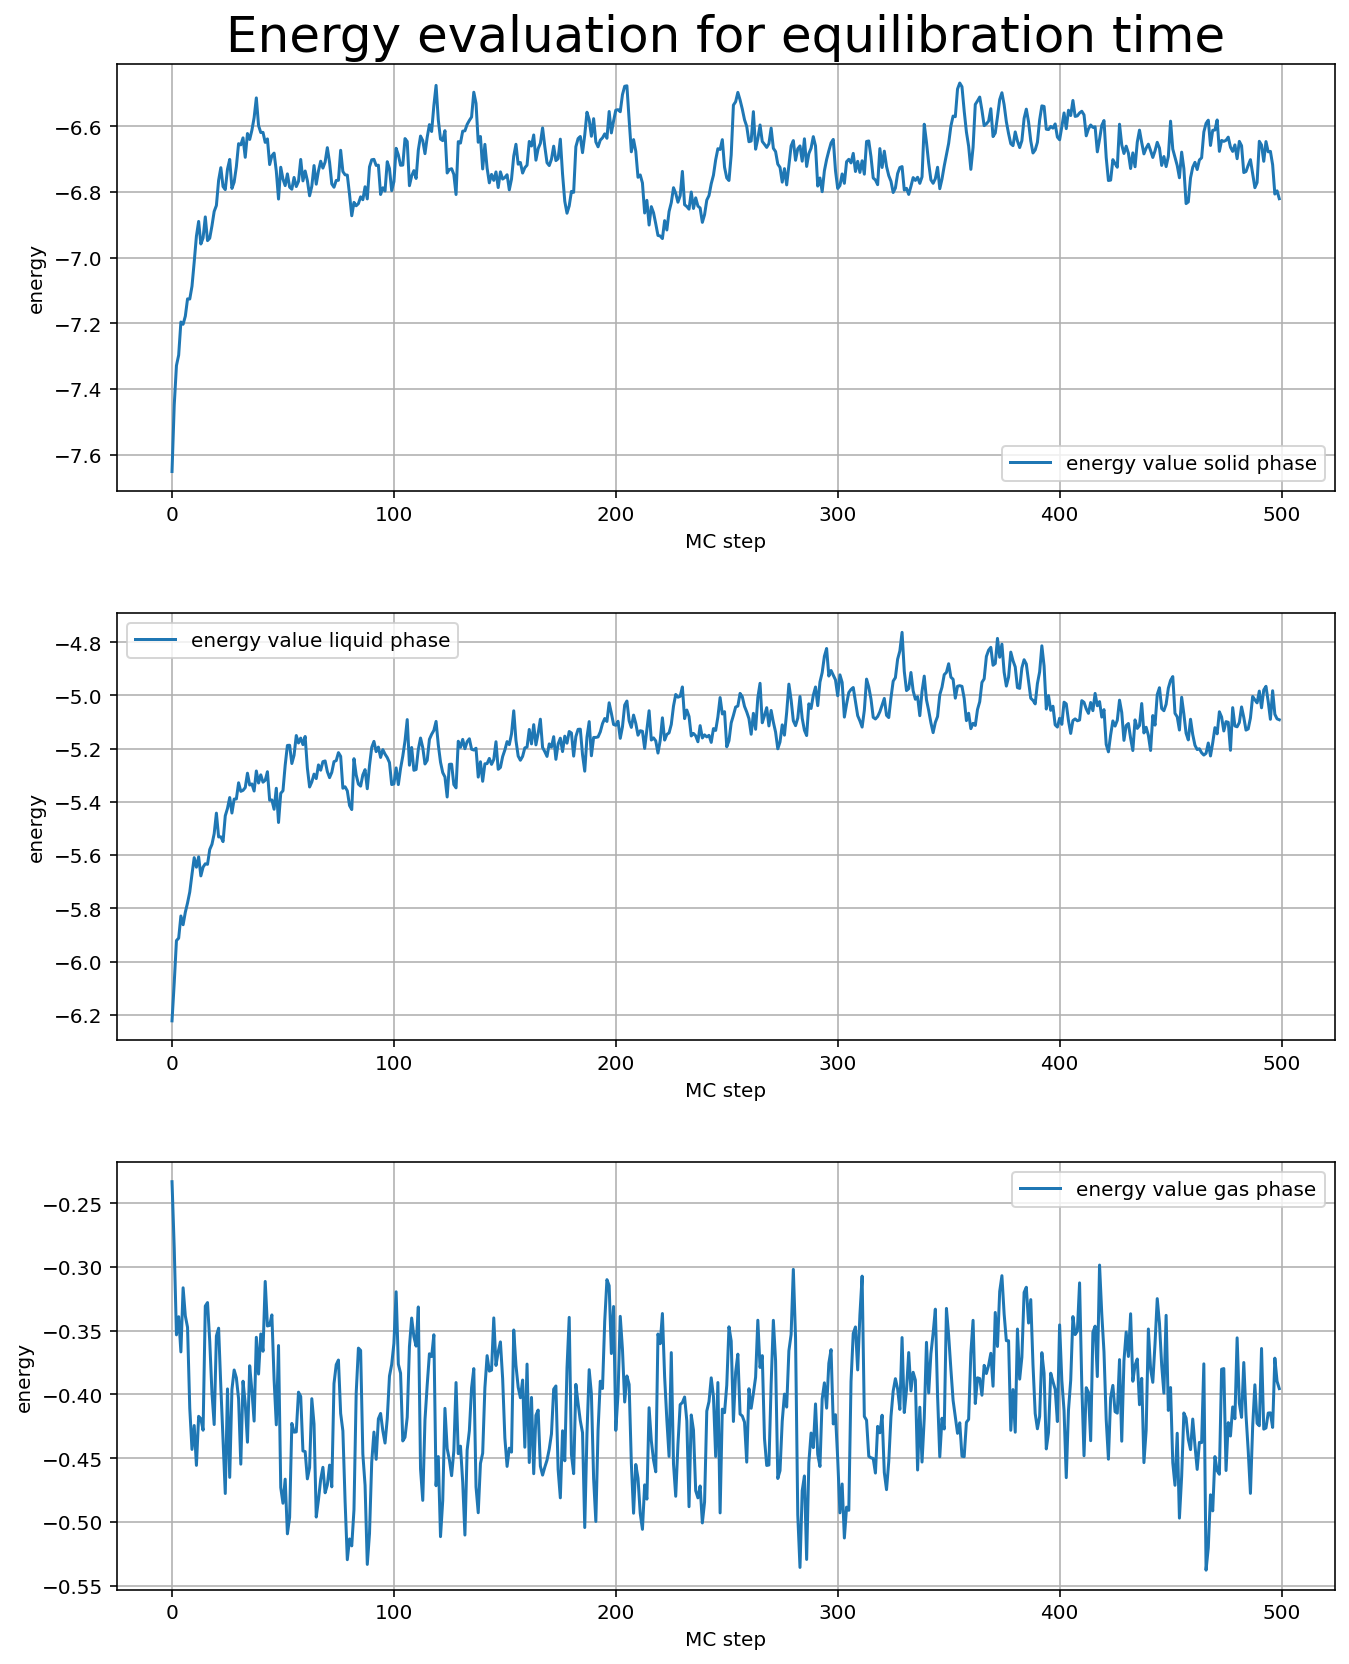

In [6]:
fig, ax = plt.subplots(3, figsize = (10,12))
fig.tight_layout(pad = 4.0)
ax[0].plot(MC_step, solid_energy_equi, label = "energy value solid phase")
ax[1].plot(MC_step, liquid_energy_equi, label = "energy value liquid phase")
ax[2].plot(MC_step, gas_energy_equi, label = "energy value gas phase")
for i in range(3):
    ax[i].set_xlabel("MC step")
    ax[i].set_ylabel("energy")
    ax[i].legend()
    ax[i].grid(True)
ax[0].set_title("Energy evaluation for equilibration time", fontsize = 25)
plt.show()

The choice for the equilibration time is taken as 200 MC steps

In [7]:
MC_step, solid_energy = np.loadtxt("Solid_sim/Autocorr_err_solid.dat", usecols=(0,1), unpack='true')
MC_step, liquid_energy = np.loadtxt("Liquid_sim/Autocorr_err_liquid.dat", usecols=(0,1), unpack='true')
MC_step, gas_energy = np.loadtxt("Gas_sim/Autocorr_err_gas.dat", usecols=(0,1), unpack='true')

In [8]:
L = np.arange(10,int(np.size(solid_energy)/100),10)
out_solid = data_block_err(solid_energy, L)
out_liquid = data_block_err(liquid_energy, L)
out_gas = data_block_err(gas_energy, L)

(0.0, 1.0, 0.0, 1.0)

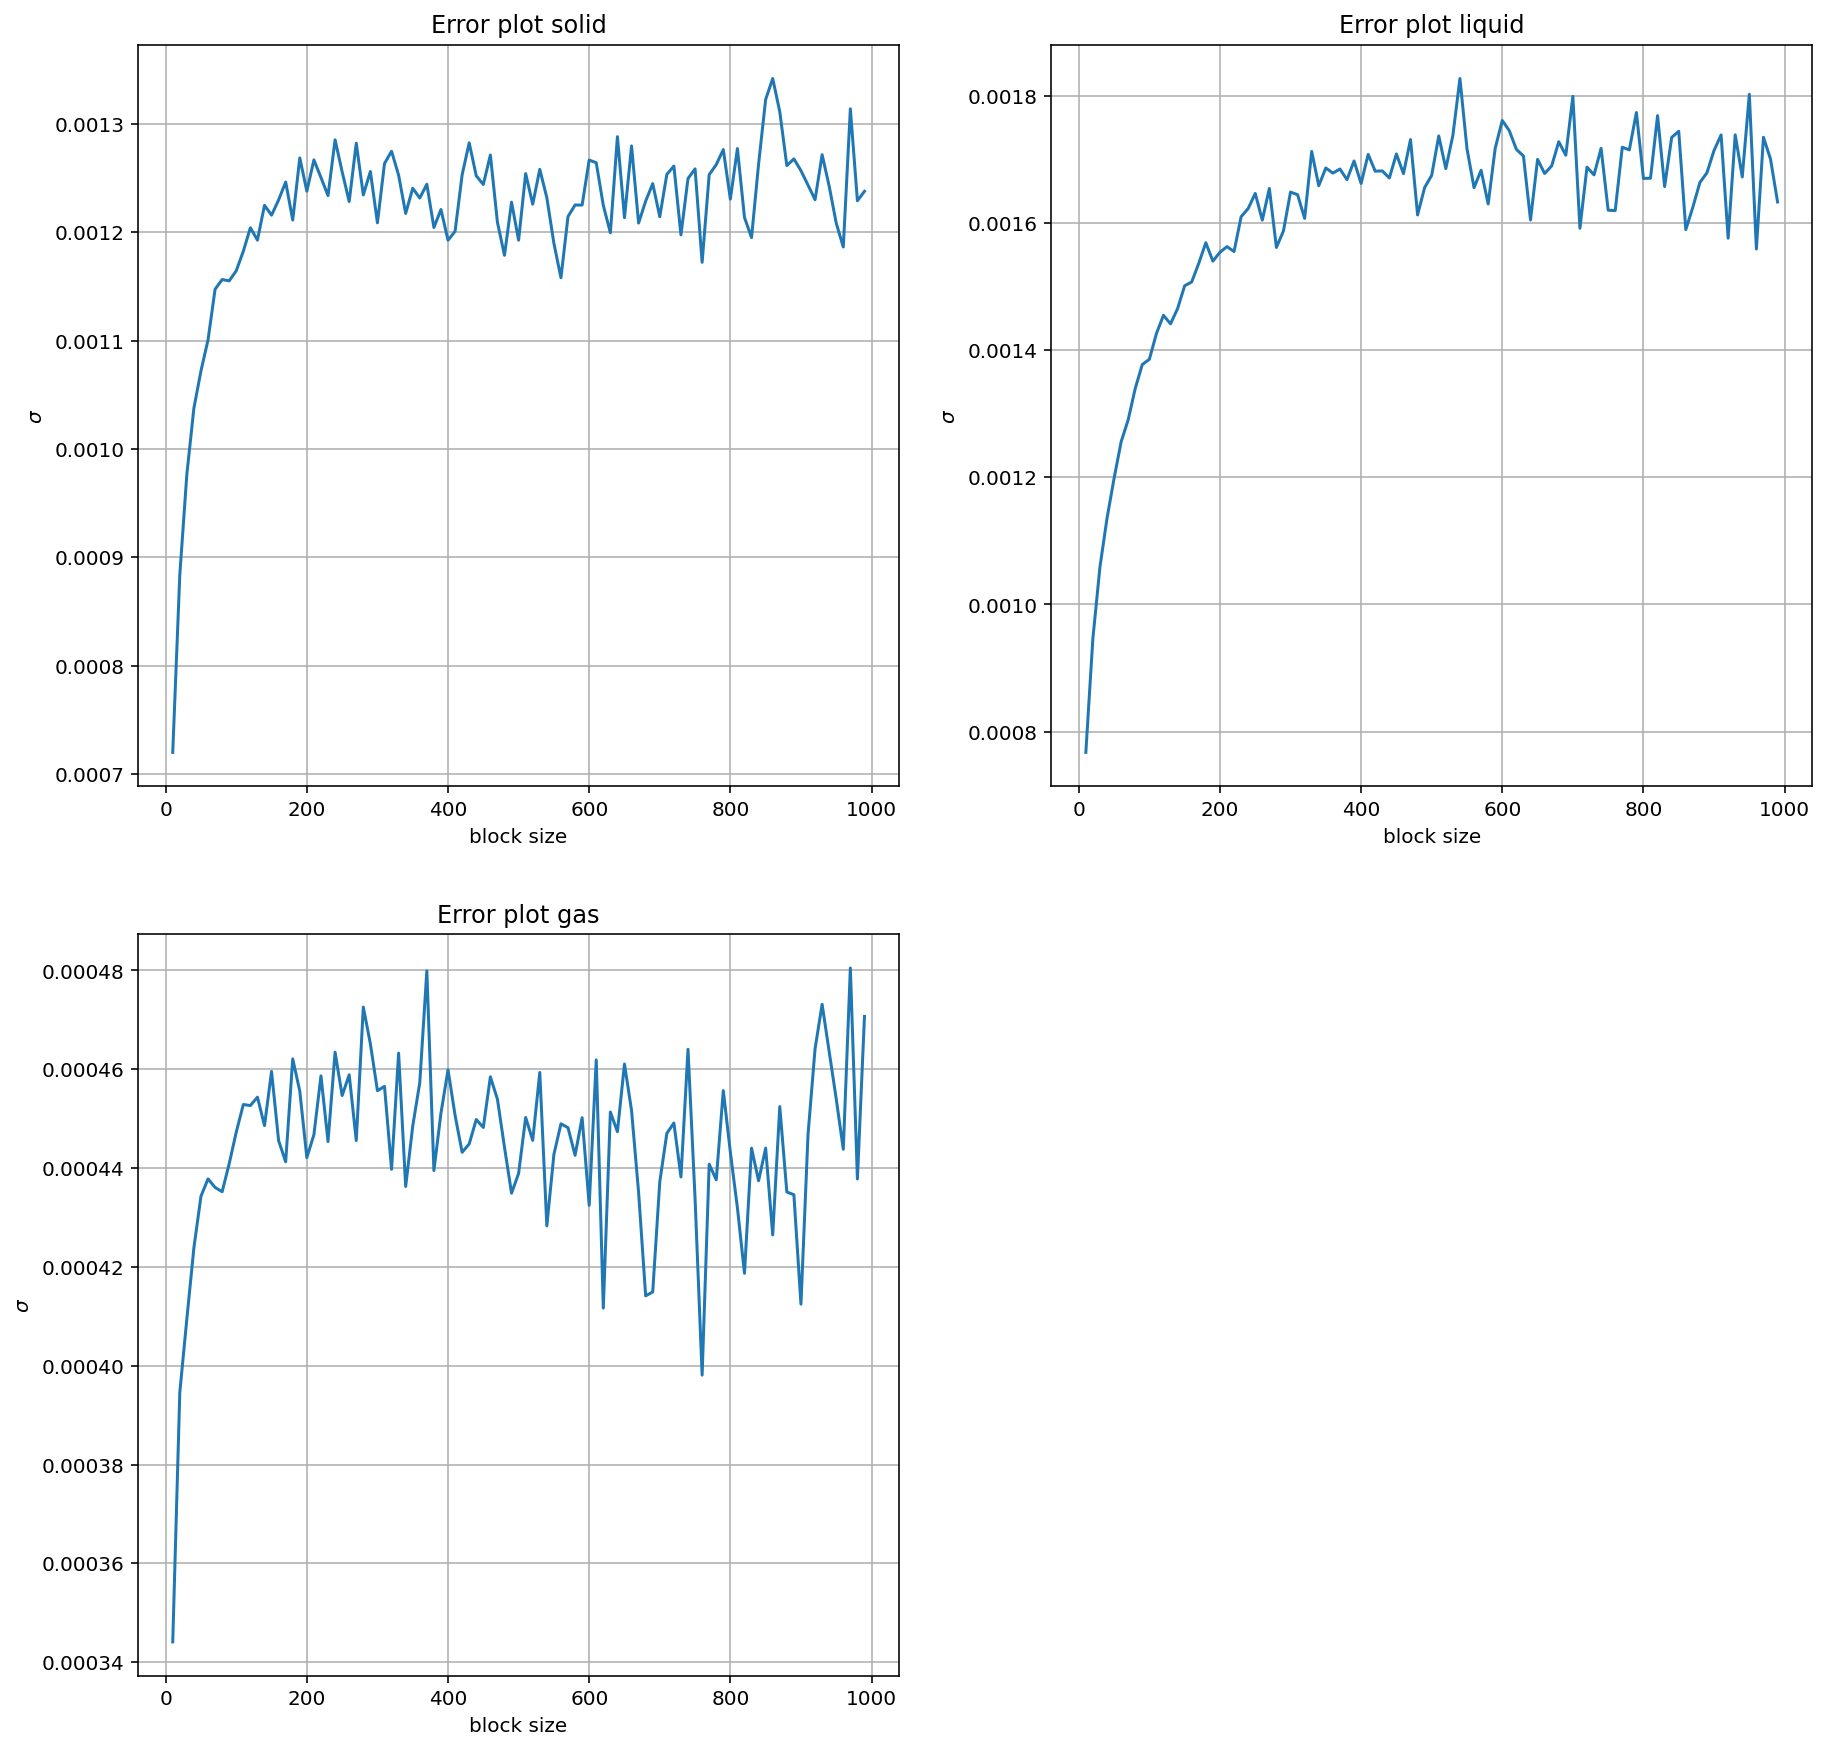

In [9]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].plot(L,out_solid)
ax[0,1].plot(L,out_liquid)
ax[1,0].plot(L,out_gas)
ax[0,0].set_title("Error plot solid")
ax[0,1].set_title("Error plot liquid")
ax[1,0].set_title("Error plot gas")
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("block size")
        ax[i,j].set_ylabel("$\sigma$")
        ax[i,j].grid(True)
ax[1,1].axis("off")

In [10]:
size = np.arange(1,500)
S = []
L = []
G = []
for i in size:
    S.append(np.mean(solid_energy[:-i]*solid_energy[i:])-np.mean(solid_energy[:-i])*np.mean(solid_energy[i:]))
    L.append(np.mean(liquid_energy[:-i]*liquid_energy[i:])-np.mean(liquid_energy[:-i])*np.mean(liquid_energy[i:]))
    G.append(np.mean(gas_energy[:-i]*gas_energy[i:])-np.mean(gas_energy[:-i])*np.mean(gas_energy[i:]))

S = S/np.cov(solid_energy,solid_energy)[0][1]
L = L/np.cov(liquid_energy,liquid_energy)[0][1]
G = G/np.cov(gas_energy,gas_energy)[0][1]


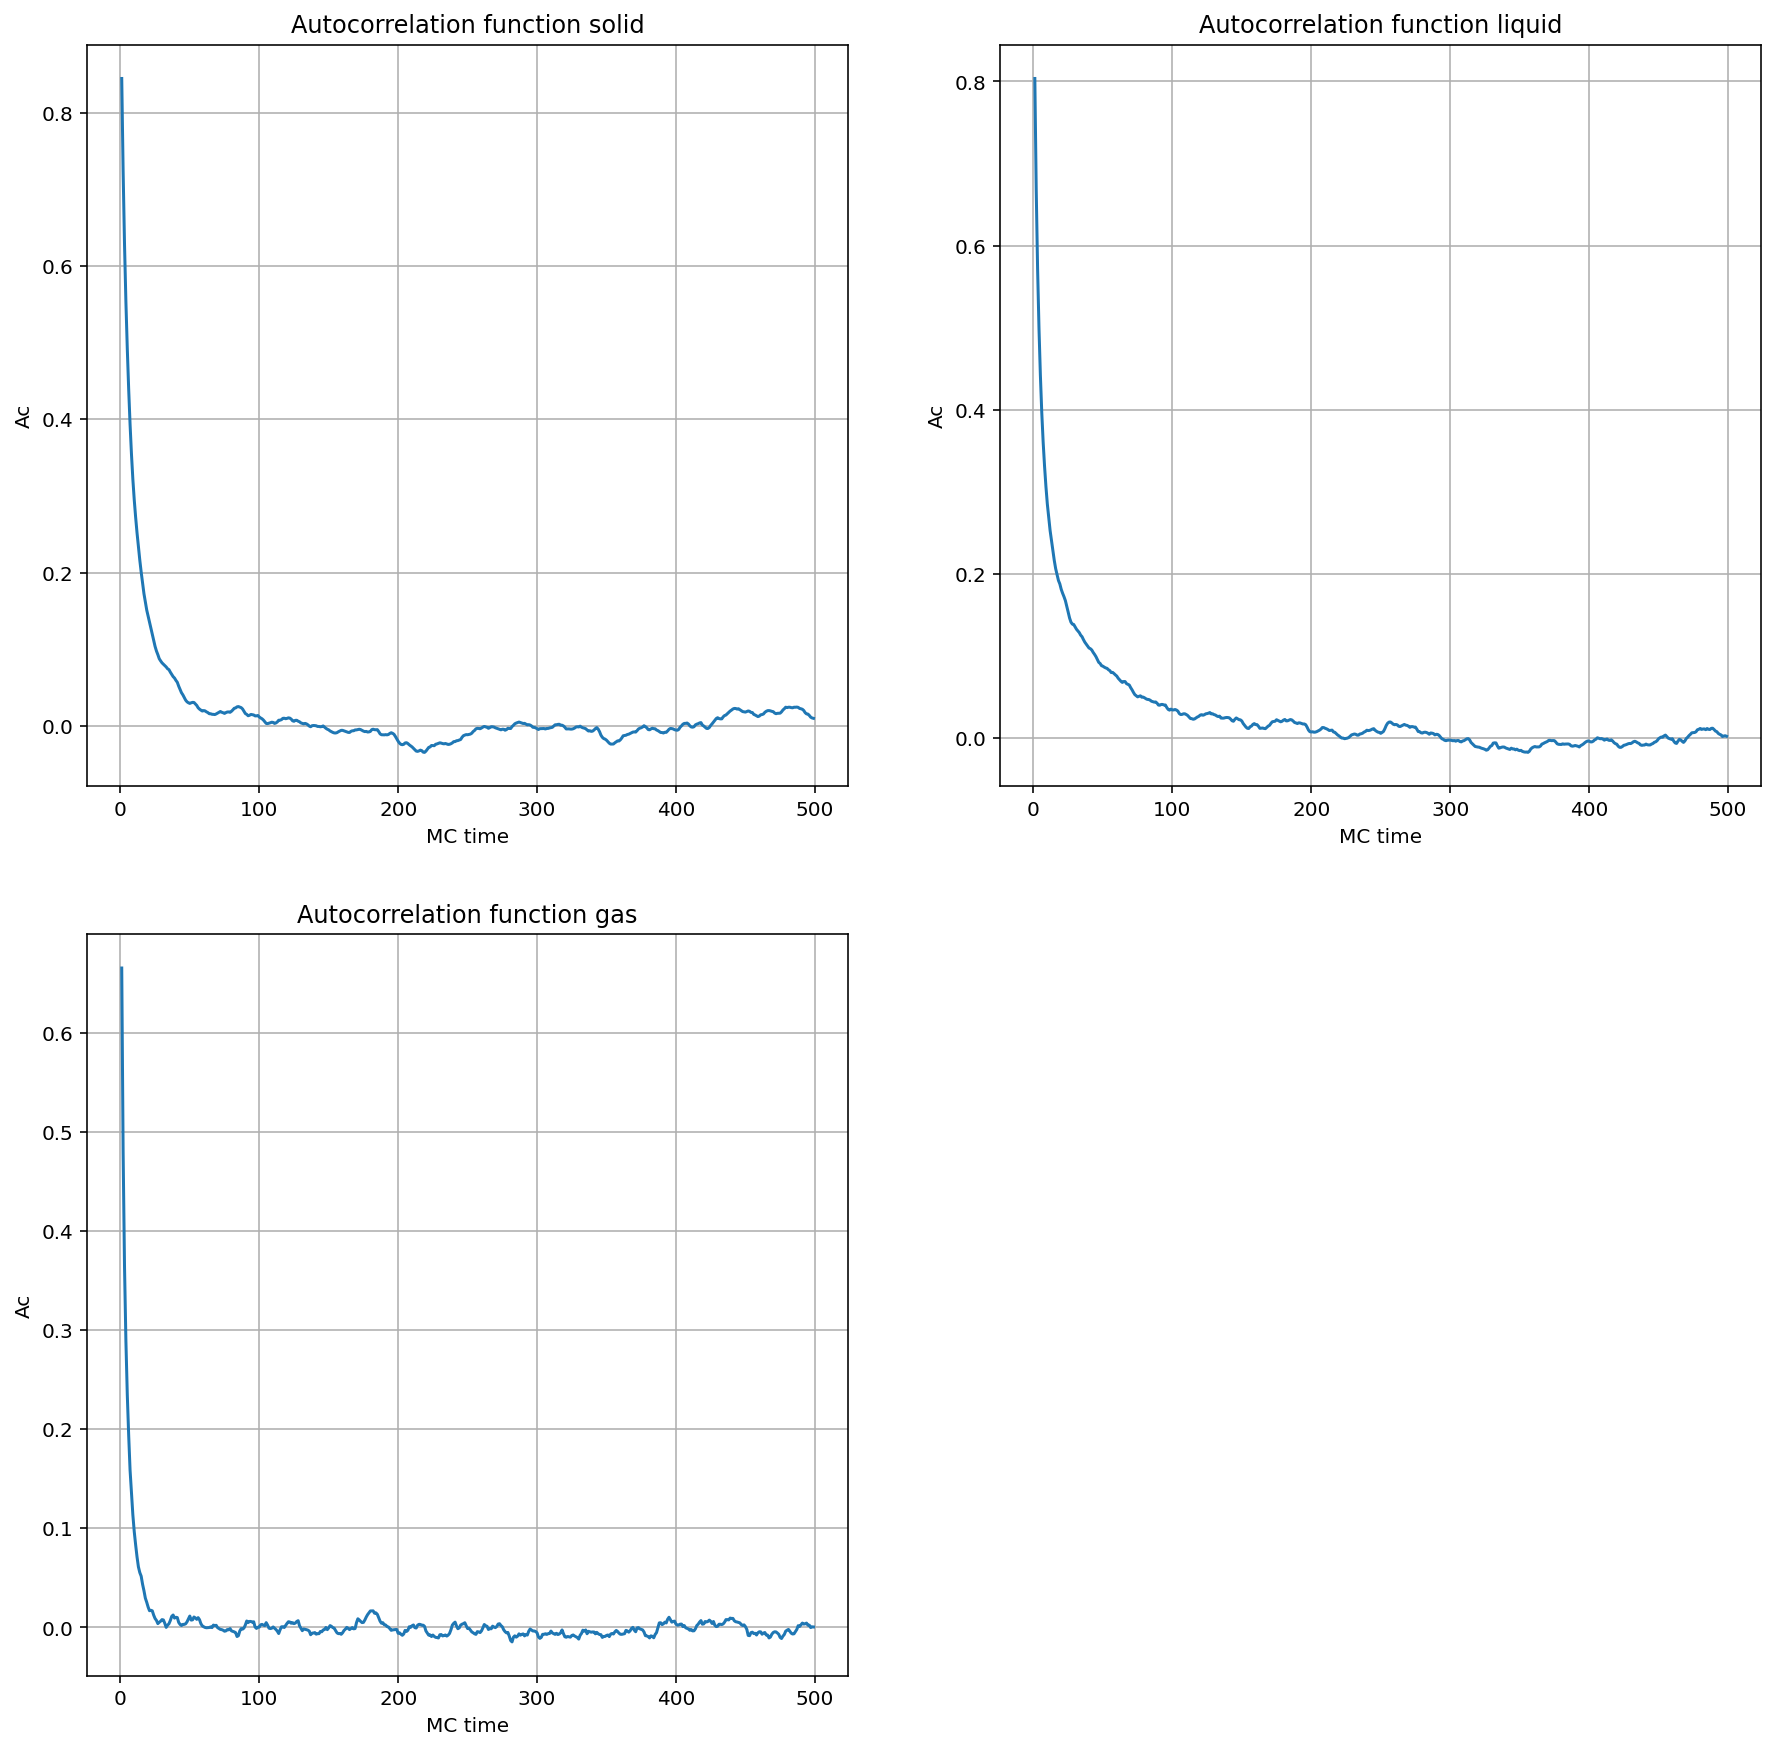

In [11]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].plot(size,S)
ax[0,1].plot(size,L)
ax[1,0].plot(size,G)
ax[0,0].set_title("Autocorrelation function solid")
ax[0,1].set_title("Autocorrelation function liquid")
ax[1,0].set_title("Autocorrelation function gas")
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("MC time")
        ax[i,j].set_ylabel("Ac")
        ax[i,j].grid(True)
ax[1,1].axis("off")
plt.show()

### Radial distribution function

For each phase the radial distribution functions $g(r)$ are computed. The expression of $g$ reads:
$$
g(r) = \frac{1}{\rho\Delta V(r)N}\langle\sum\sum_{i\neq j = 1}^{N} \delta[|\vec{r}-|(\vec{r}_i-\vec{r}_j|)\rangle
$$

where

$$
\Delta V (r) = \frac{4\pi}{3}[(r+dr)^3-r^3]
$$

Computationally wise this means for each MC step checking all the distances between particles and filling an histogram with the relative counts of the distances. The error is computed as usual with data blocking

Below are shown the plots for the radial distribution functions in the three phases. They are calculated both using the Metropolis algorithm and the Verlet algorithm. The results are then superimposed. From the computational point of view for the Verlet once again an equilibration time was needed; since the conditions are the same as those in exercise 04 the same equilibration time was used (2000 time steps for solid and liquid phase and 5000 for gas phase). Data blocking for Veret has been performed using 20 blocks of 1000 steps each

In [12]:
rad_solid, err_rad_solid = np.loadtxt("Solid_sim/output_radial.dat", usecols=(2, 3), unpack='true')
rad_solid_Verlet, err_rad_solid_Verlet = np.loadtxt("Solid_sim/output_radial_Verlet.dat", usecols=(2, 3), unpack='true')
rad_liquid, err_rad_liquid = np.loadtxt("Liquid_sim/output_radial.dat", usecols=(2, 3), unpack='true')
rad_gas, err_rad_gas = np.loadtxt("Gas_sim/output_radial.dat", usecols=(2, 3), unpack='true')
rad_liquid_Verlet, err_rad_liquid_Verlet = np.loadtxt("Liquid_sim/output_radial_Verlet.dat", usecols=(2, 3), unpack='true')
rad_gas_Verlet, err_rad_gas_Verlet = np.loadtxt("Gas_sim/output_radial_Verlet.dat", usecols=(2, 3), unpack='true')

In order to return from natural units to SI units the value of the fundamental constants are needed; in this case they are:
- unit of length: $\sigma = 0.34 \times 10^{-9} m$
- unit of temperature: $\frac{\epsilon}{k_B} = 120 K$
- unit of mass: $m = 66.31 \times 10^{-27} Kg$
- unit of energy: $\epsilon = k_B \frac{\epsilon}{k_B} = 1.656\times 10^{-21} J$
- unit of pressure: $p = \frac{\epsilon}{\sigma^3} = 421 Pa$

In [13]:
sigma = 0.34*pow(10,-9)
box = 4.61329/2
binsize = box/995
epsilon = 1.380*pow(10,-23)*120
p = epsilon/pow(sigma,3)

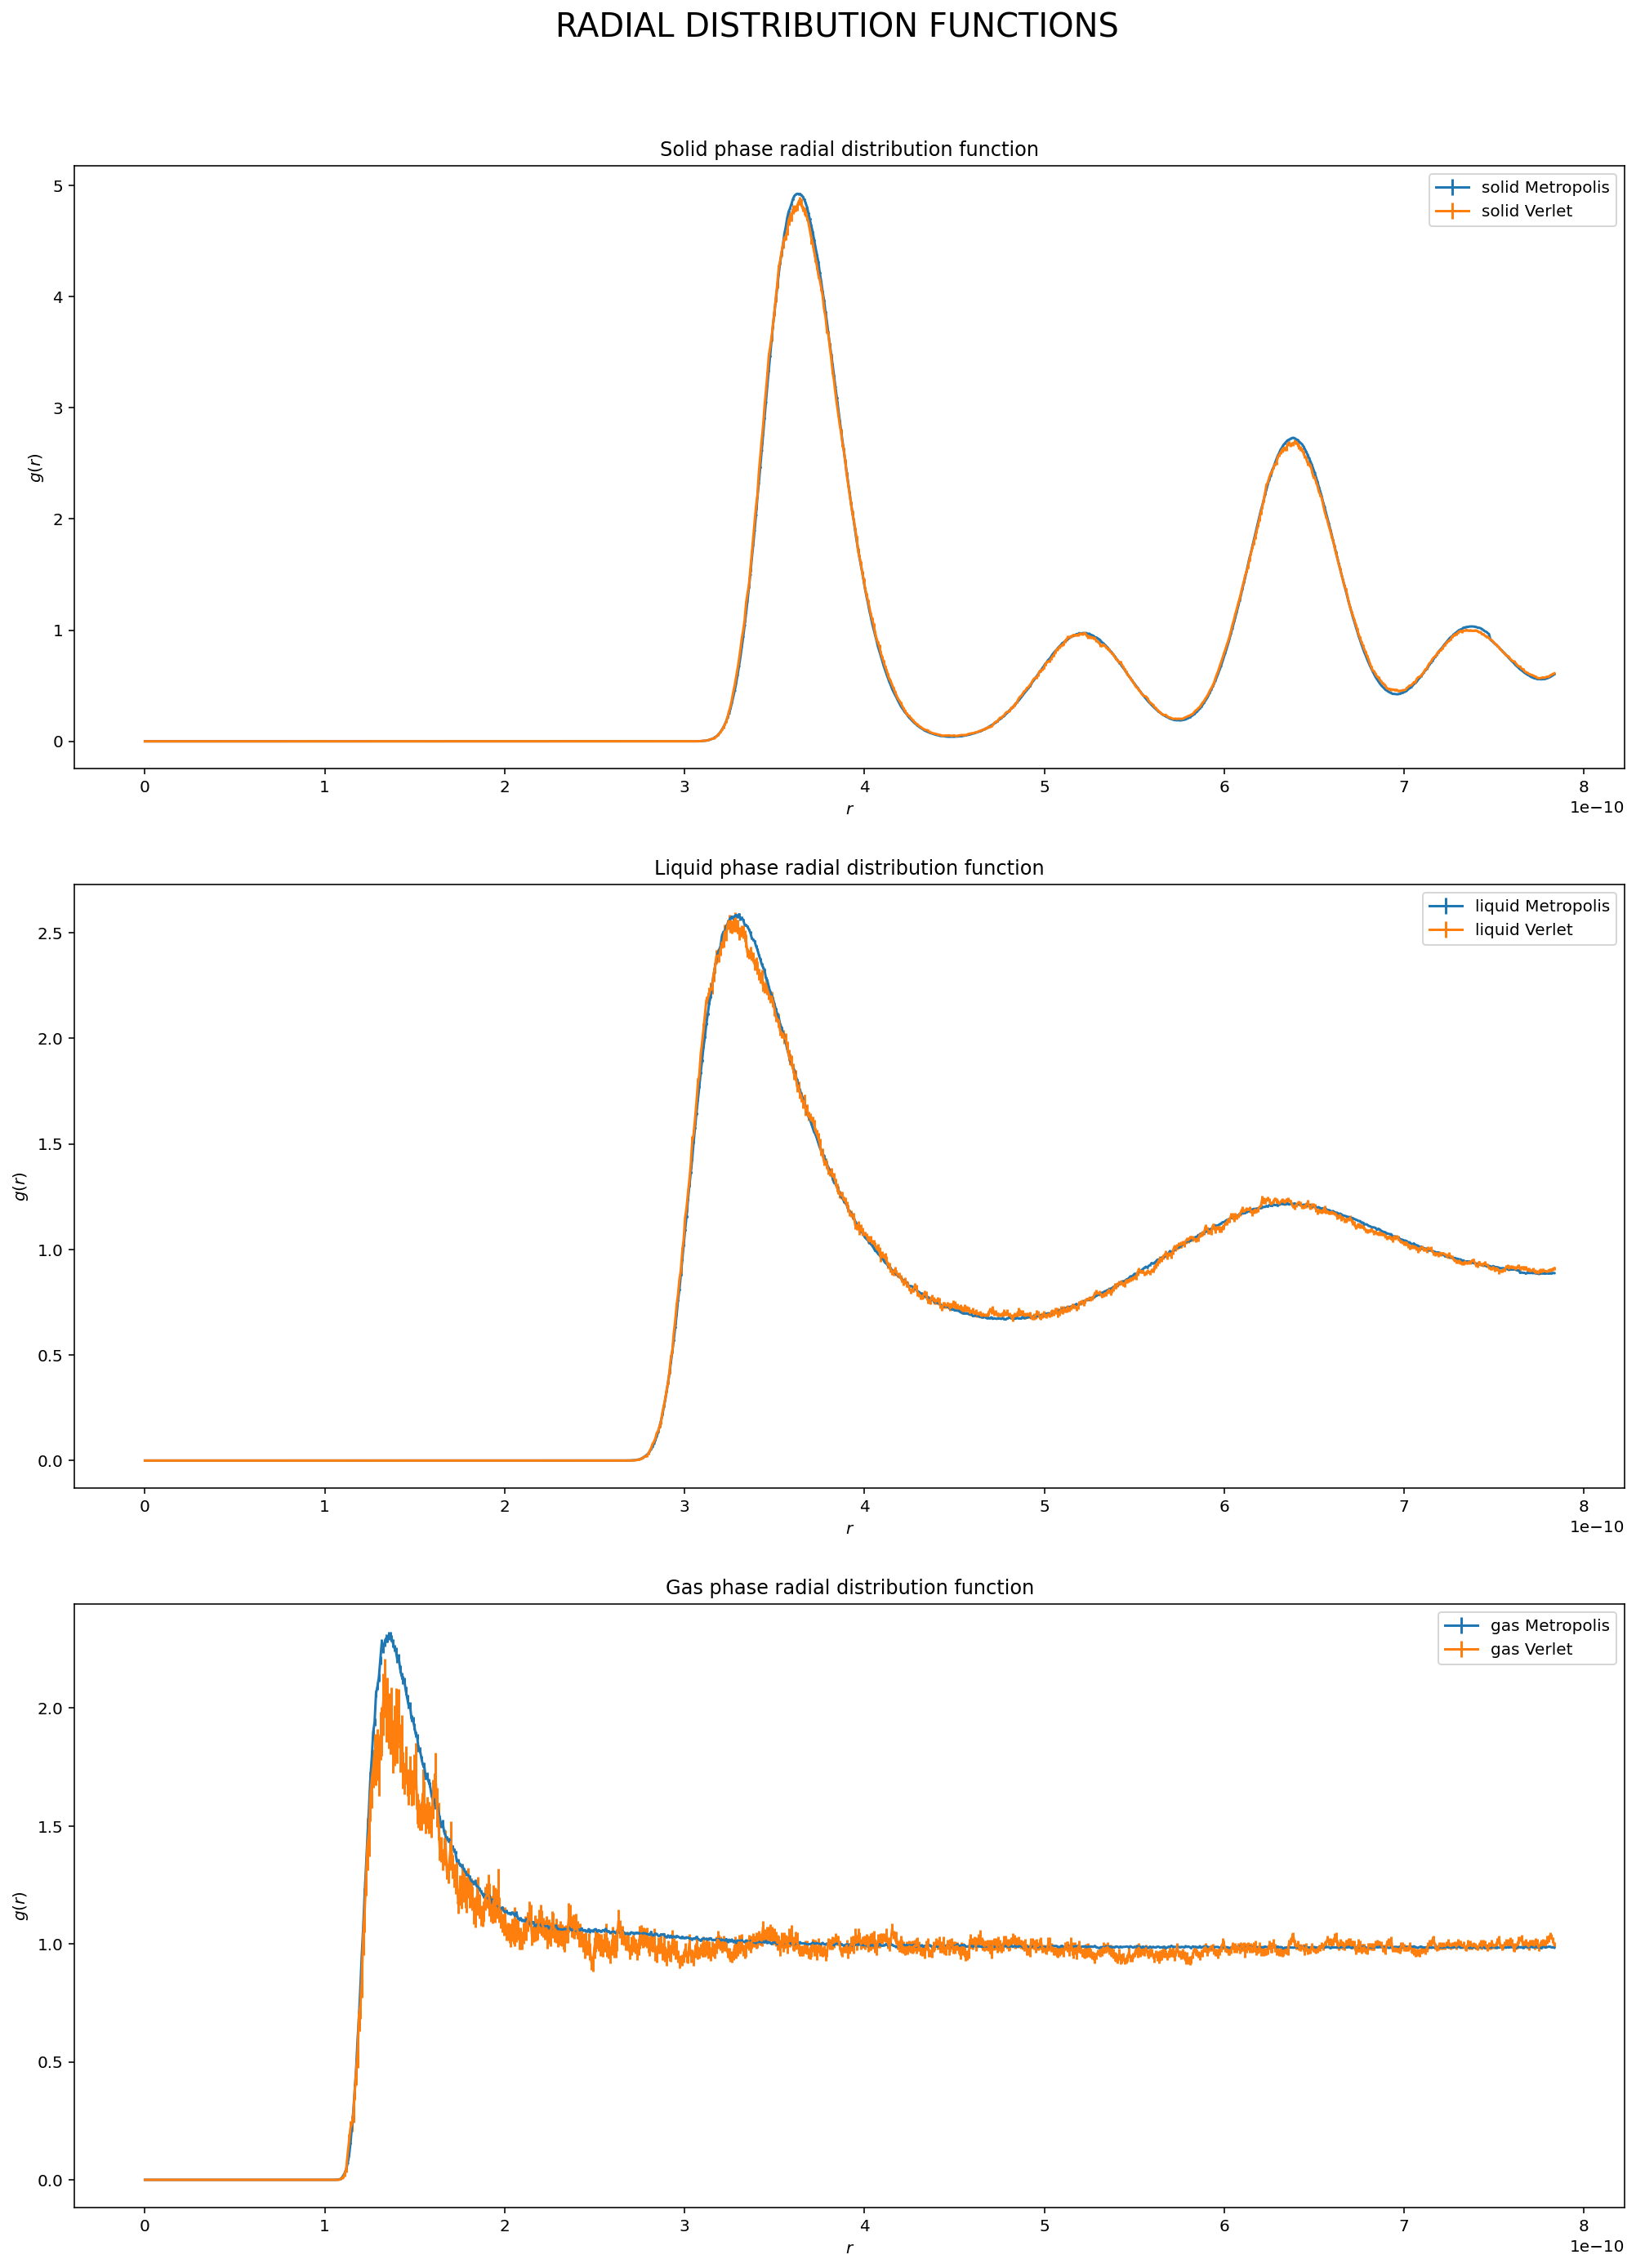

In [14]:
t1 = np.arange(0,np.size(rad_solid))
t1 = t1*sigma*binsize
fig, axs = plt.subplots(3,1,figsize = (15,20))
fig.suptitle("RADIAL DISTRIBUTION FUNCTIONS", fontsize = 20)
fig.tight_layout(pad = 5.0)
axs[0].errorbar(t1, rad_solid, err_rad_solid, label = "solid Metropolis")
axs[0].errorbar(t1, rad_solid_Verlet, err_rad_solid_Verlet, label = "solid Verlet")
axs[1].errorbar(t1, rad_liquid, err_rad_liquid, label = "liquid Metropolis")
axs[1].errorbar(t1, rad_liquid_Verlet, err_rad_liquid_Verlet, label = "liquid Verlet")
axs[2].errorbar(t1, rad_gas, err_rad_gas, label = "gas Metropolis")
axs[2].errorbar(t1, rad_gas_Verlet, err_rad_gas_Verlet, label = "gas Verlet")
axs[0].set_title("Solid phase radial distribution function")
axs[1].set_title("Liquid phase radial distribution function")
axs[2].set_title("Gas phase radial distribution function")
for i in range(3):
    axs[i].set_xlabel("$r$")
    axs[i].set_ylabel("$g(r)$")
    axs[i].legend()

The plots for the radial distribution function overlap better for the liquid and solid phase. The worse overlap for the gaseous phase could be found in two facts that:
- in the Verlet algorithm the temperature oscillates more than the other two cases even after a longer equilibration time; this means that the "initial conditions" (after equilibration) are different for Metropolis and Verlet
- the 50% empirical rule for the gas is not well met: this can mean that the sampling of the positional configurations of the gas might be less accurate than the solid and liquid phases 

Finally the calculation with Metropolis for energy per particle and pressure are shown for the three phases:

In [15]:
blk_num_solid, energy_solid, err_energy_solid = np.loadtxt("Solid_sim/output_epot.dat", usecols = (0,2,3)
                                                           , unpack = True)
blk_num_liquid, energy_liquid, err_energy_liquid = np.loadtxt("Liquid_sim/output_epot.dat", usecols = (0,2,3)
                                                           , unpack = True)
blk_num_gas, energy_gas, err_energy_gas = np.loadtxt("Gas_sim/output_epot.dat", usecols = (0,2,3)
                                                           , unpack = True)

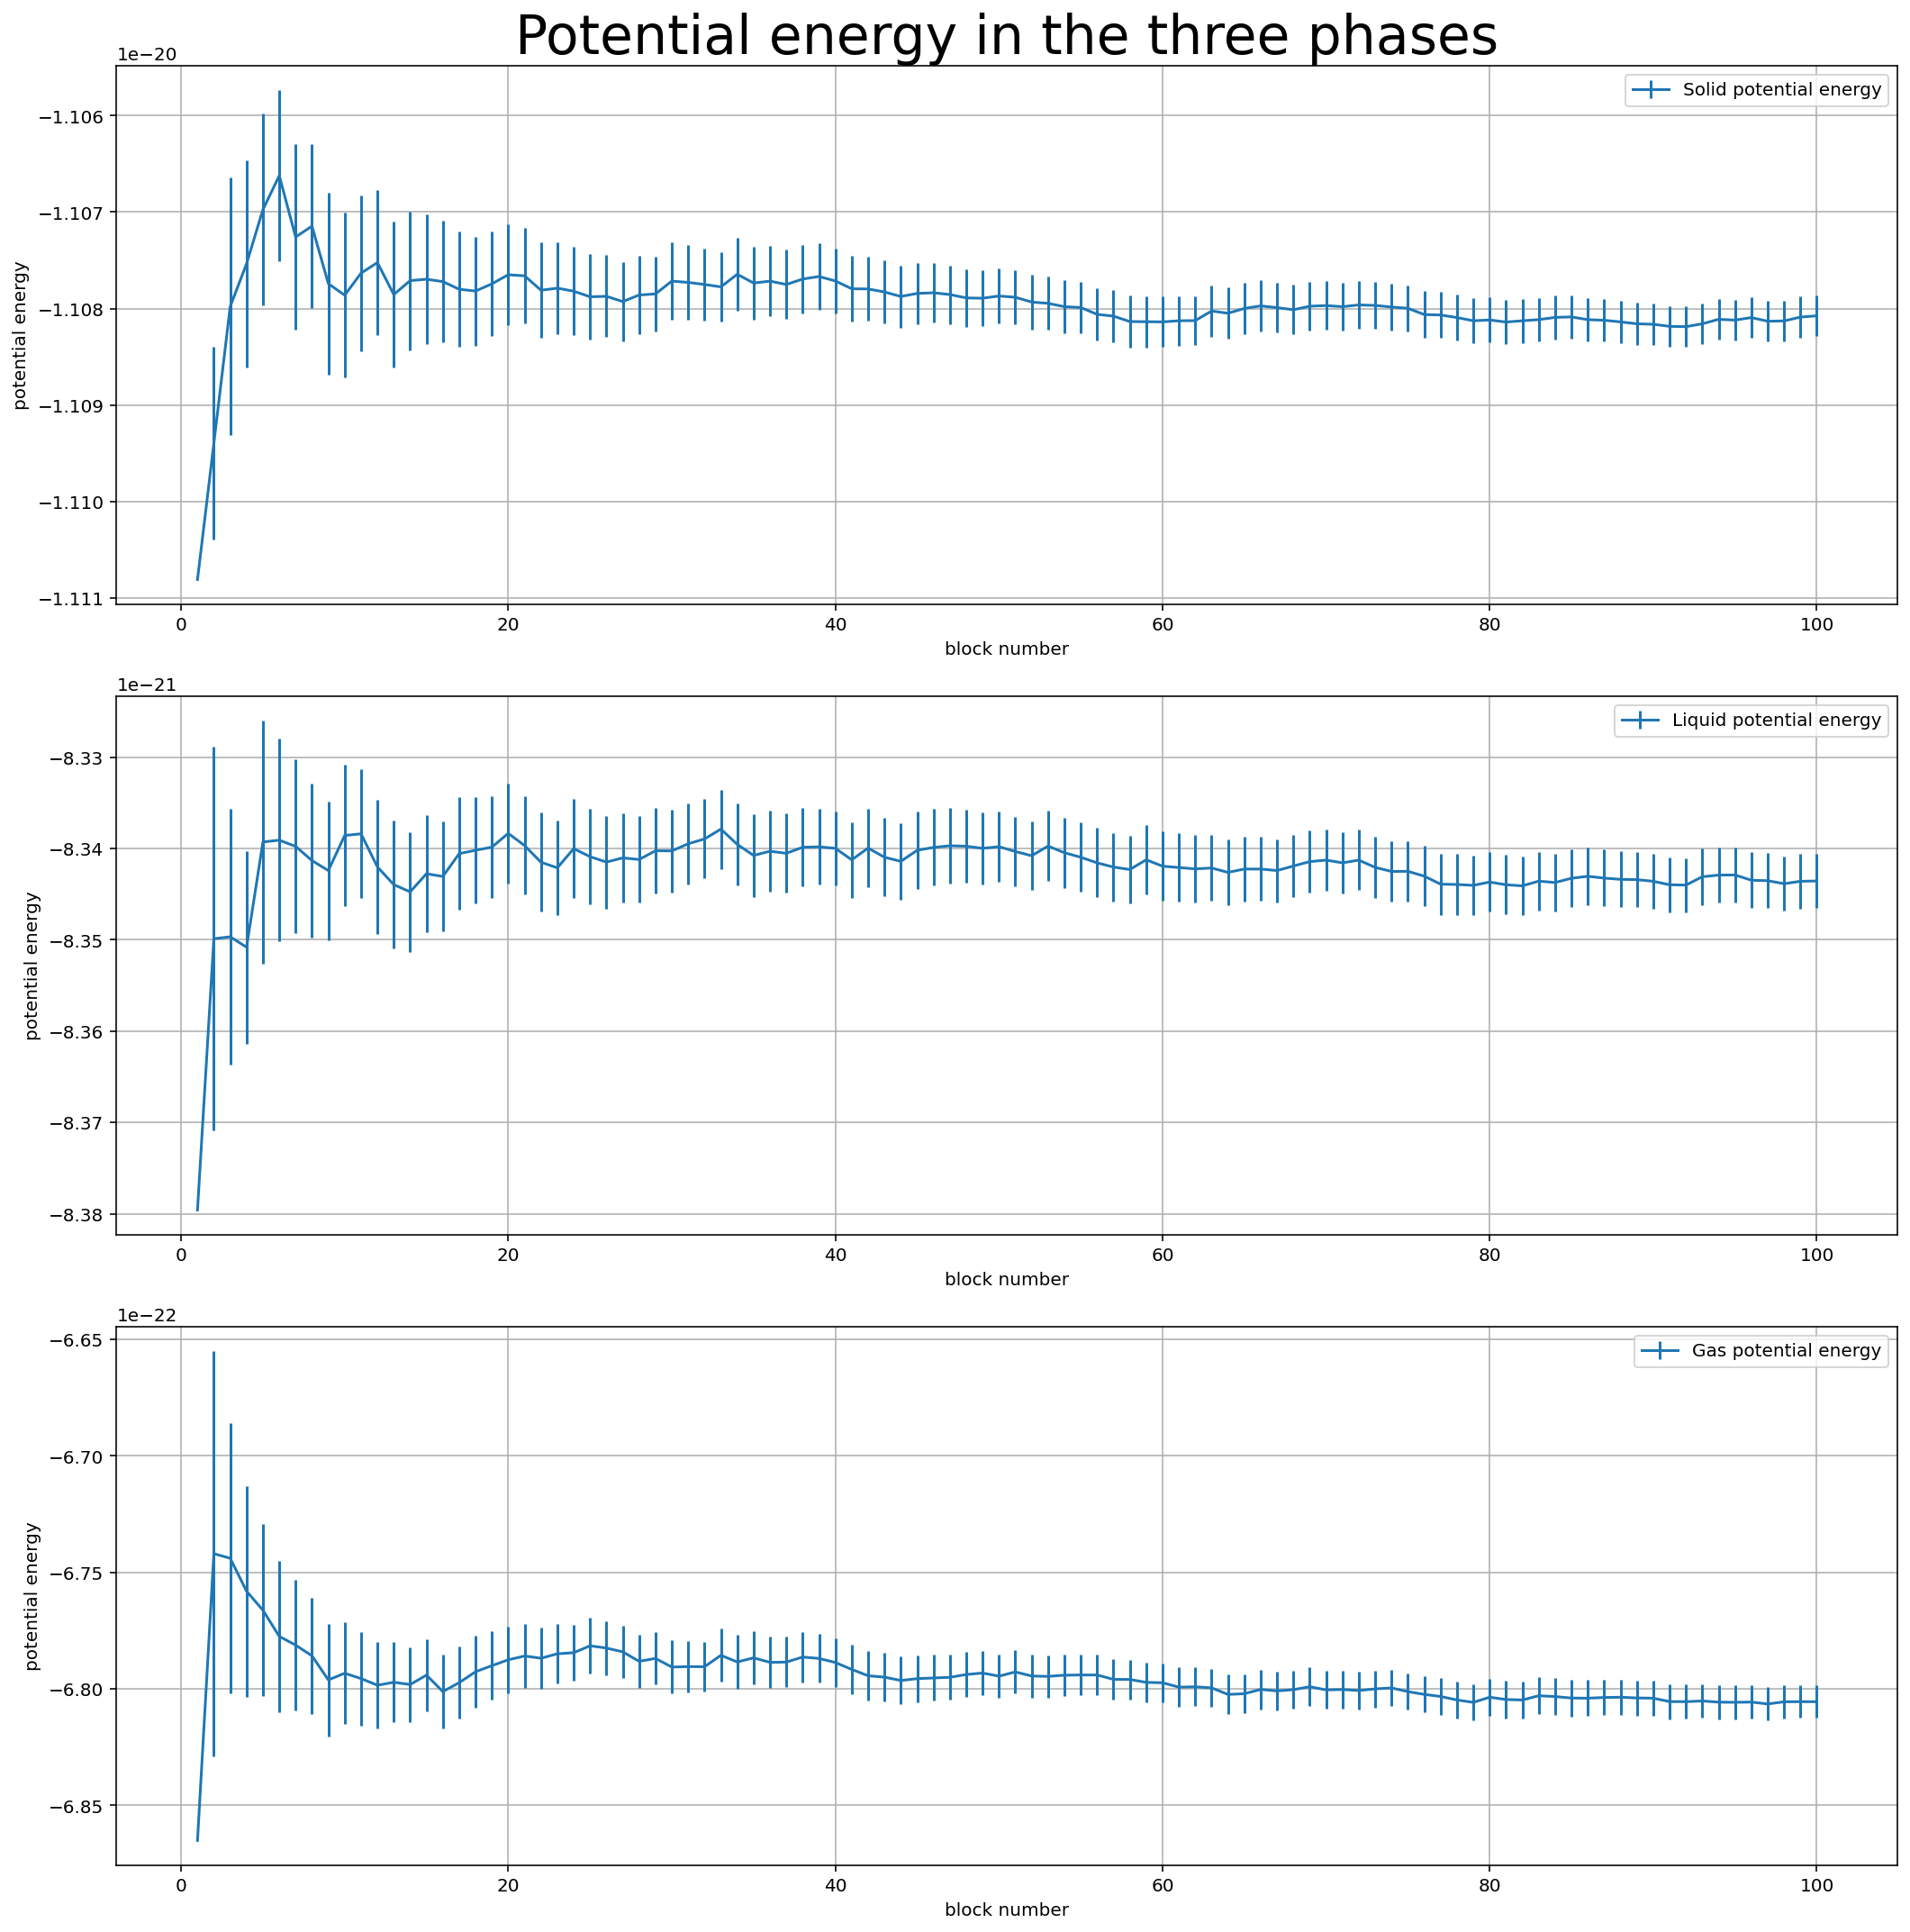

In [16]:
fig, ax = plt.subplots(3, figsize = (15,15))
fig.tight_layout(pad = 3.0)
ax[0].errorbar(blk_num_solid,energy_solid*epsilon,yerr = err_energy_solid*epsilon, label = "Solid potential energy")
ax[1].errorbar(blk_num_liquid,energy_liquid*epsilon,yerr = err_energy_liquid*epsilon, label = "Liquid potential energy")
ax[2].errorbar(blk_num_gas,energy_gas*epsilon,yerr = err_energy_gas*epsilon, label = "Gas potential energy")
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("block number")
    ax[i].set_ylabel("potential energy")
    ax[i].grid(True)
ax[0].set_title("Potential energy in the three phases", fontsize = 30)
plt.show()

In [17]:
blk_num_solid, pressure_solid, err_pressure_solid = np.loadtxt("Solid_sim/output_press.dat", usecols = (0,2,3)
                                                           , unpack = True)
blk_num_liquid, pressure_liquid, err_pressure_liquid = np.loadtxt("Liquid_sim/output_press.dat", usecols = (0,2,3)
                                                           , unpack = True)
blk_num_gas, pressure_gas, err_pressure_gas = np.loadtxt("Gas_sim/output_press.dat", usecols = (0,2,3)
                                                           , unpack = True)

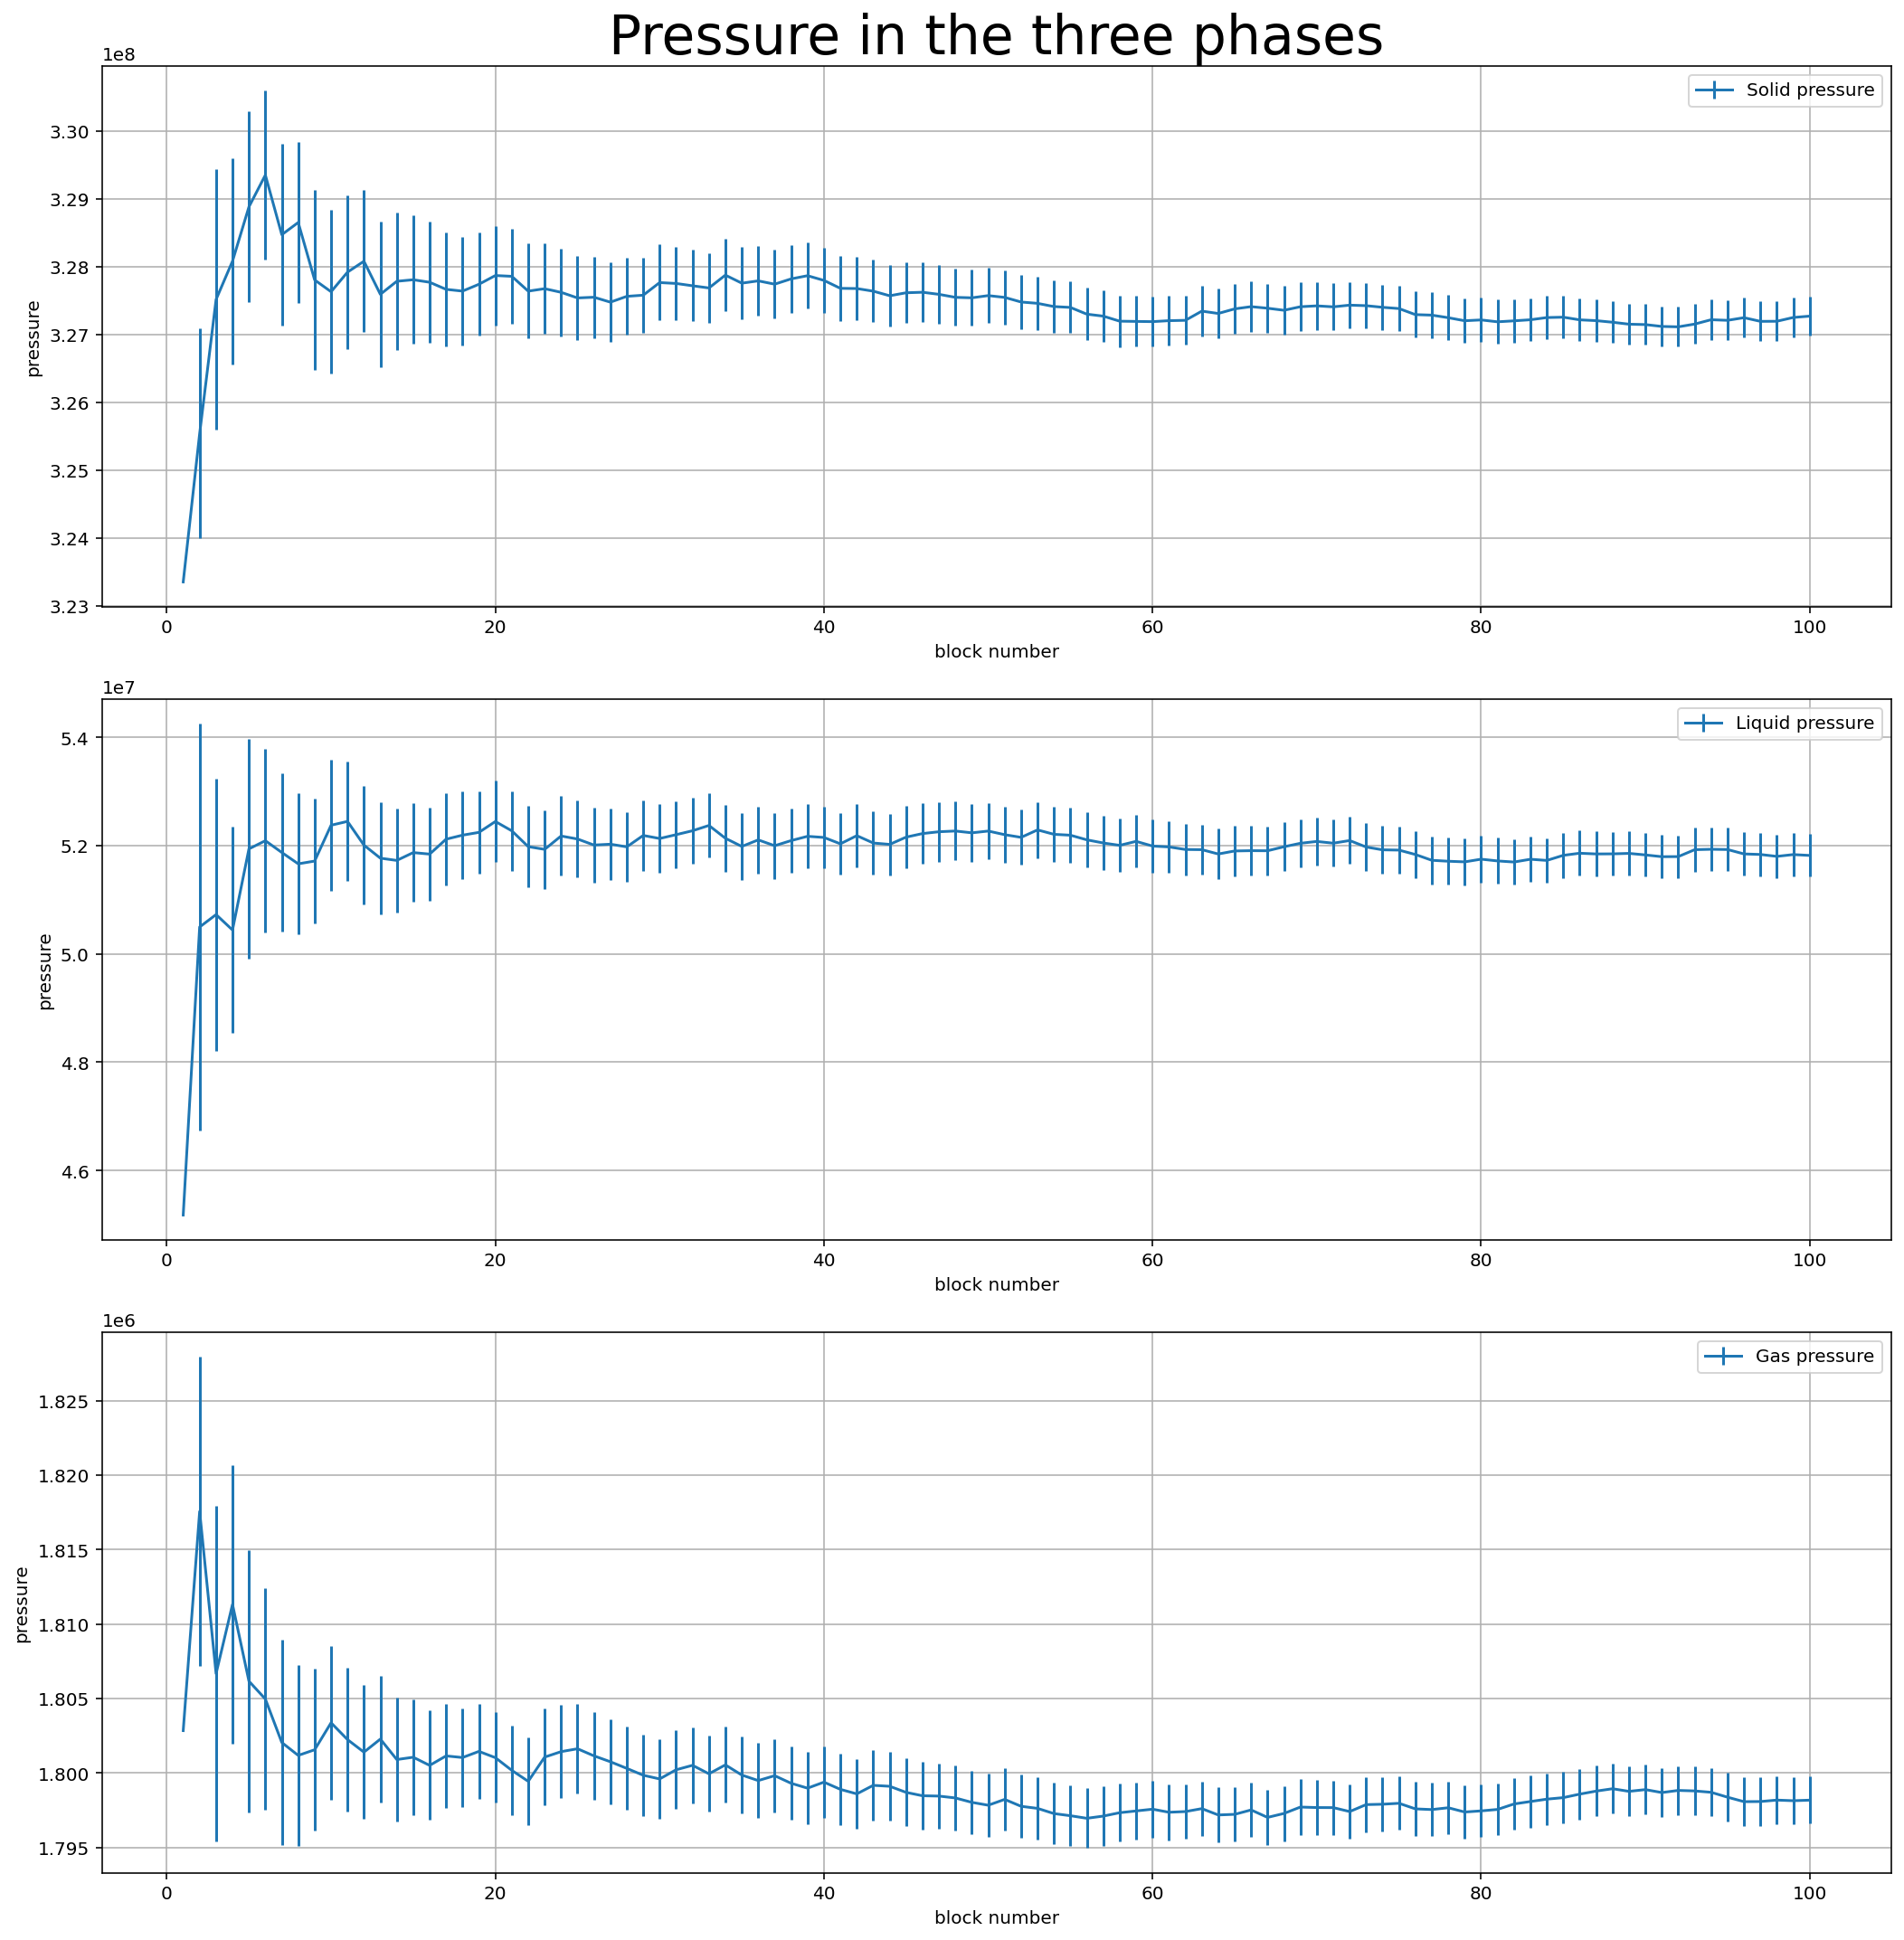

In [18]:
fig, ax = plt.subplots(3, figsize = (15,15))
fig.tight_layout(pad = 3.0)
ax[0].errorbar(blk_num_solid,pressure_solid*p,yerr = err_pressure_solid*p, label = "Solid pressure")
ax[1].errorbar(blk_num_liquid,pressure_liquid*p,yerr = err_pressure_liquid*p, label = "Liquid pressure")
ax[2].errorbar(blk_num_gas,pressure_gas*p,yerr = err_pressure_gas*p, label = "Gas pressure")
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("block number")
    ax[i].set_ylabel("pressure")
    ax[i].grid(True)
ax[0].set_title("Pressure in the three phases", fontsize = 30)
plt.show()